In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip /content/drive/MyDrive/colab/images.zip
# !pip install wandb

In [2]:
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

import wandb

In [3]:
def set_seed(seed):
    # torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
# warnings.filterwarnings("ignore")
set_seed(3407)
wandb.login()

# model.zero_grad()
# loss.backward()
# optimizer.step()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: seara. Use `wandb login --relogin` to force relogin


True

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATAROOT = (
    "/home/seara/Desktop/Github/vk-try/images"
    if os.path.isdir("/home/seara/Desktop/Github/vk-try/images")
    else "/content/images"
)
WORKERS = 4
BATCH_SIZE = 128
NUM_EPOCHS = 1000
LR = 0.0002
BETA1 = 0.5
BETA2 = 0.999
IMAGE_SIZE = (64, 64)
LATENT_DIM = 100
FEATURES = 64

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim, features):
        super().__init__()
        self.net = nn.Sequential(
            *self.block(latent_dim, features * 16, 4, 1, 0),
            *self.block(features * 16, features * 8, 4, 2, 1),
            *self.block(features * 8, features * 4, 4, 2, 1),
            *self.block(features * 4, features * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                in_channels=features * 2,
                out_channels=3,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=True,
            ),
            nn.Tanh(),
        )

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3)
        )

    def forward(self, x):
        return self.net(x)

In [7]:
class GaussianNoise(nn.Module):                         # Try noise just for real or just for fake images.
    def __init__(self, std=0.1, decay_rate=0):
        super().__init__()
        self.std = std
        self.decay_rate = decay_rate

    def decay_step(self):
        self.std = max(self.std - self.decay_rate, 0)

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

In [8]:
class Discriminator(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=features,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=True,
            ),
            nn.LeakyReLU(0.2, inplace=True),
            *self.block(features, features * 2, 4, 2, 1),
            *self.block(features * 2, features * 4, 4, 2, 1),
            *self.block(features * 4, features * 8, 4, 2, 1),
            nn.Conv2d(
                in_channels=features * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=True,
            ),
            nn.Sigmoid(),
        )

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            GaussianNoise(),
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.net(x)

In [9]:
class DCGAN:
    def __init__(
        self,
        num_epochs,
        lr,
        beta1,
        beta2,
        latent_dim,
        features,
        device,
    ):

        self.num_epochs = num_epochs
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.latent_dim = latent_dim
        self.features = features
        self.device = device

        self.G = Generator(self.latent_dim, self.features)
        self.D = Discriminator(self.features)

        self.G.to(self.device)
        self.D.to(self.device)

        self.initialize_weights(self.G)
        self.initialize_weights(self.D)

        self.loss = nn.BCELoss()

        self.d_optimizer = optim.Adam(
            self.D.parameters(), lr=self.lr, betas=(self.beta1, self.beta2)
        )
        self.g_optimizer = optim.Adam(
            self.G.parameters(), lr=self.lr, betas=(self.beta1, self.beta2)
        )

    def train(self, dataloader):
        wandb.init(project="vk_try", name="shit bro")
        # wandb.watch(model)

        self.G.train()
        self.D.train()

        self.noise_coef = 1

        for epoch in range(self.num_epochs):
            d_loss_list = []
            d_loss_real_list = []
            d_loss_fake_list = []
            g_loss_list = []
            for i, (real_images, _) in enumerate(dataloader):
                noise = torch.randn(
                    (real_images.size(0), self.latent_dim, 1, 1), device=self.device
                )
                # gauss_noise = (
                #     torch.randn(real_images.size(), device=self.device)
                #     * self.noise_coef
                #     + 0
                # )
                real_images = real_images.to(self.device)
                fake_images = self.G(noise)

                # Discriminator step
                self.D.zero_grad()

                d_real_output = self.D(real_images).flatten()
                real_labels = torch.empty_like(d_real_output).uniform_(0.7, 1.2)
                d_loss_real = self.loss(d_real_output, real_labels)

                d_fake_output = self.D(fake_images.detach()).flatten()
                fake_labels = torch.empty_like(d_fake_output).uniform_(0, 0.3)
                d_loss_fake = self.loss(d_fake_output, fake_labels)

                d_loss = (d_loss_real + d_loss_fake) / 2
                d_loss.backward()
                self.d_optimizer.step()

                # Generator step
                self.G.zero_grad()

                d_fake_output = self.D(fake_images).flatten()
                d_real_output = self.D(real_images).flatten()
                g_loss = self.loss(
                    torch.cat((d_fake_output, d_real_output)),
                    torch.cat(
                        (
                            torch.ones_like(d_fake_output, device=self.device),
                            torch.zeros_like(d_real_output, device=self.device),
                        ),
                    ),
                )

                g_loss.backward()
                self.g_optimizer.step()

                # Logging
                d_loss_list.append(d_loss.item())
                d_loss_real_list.append(d_loss_real.item())
                d_loss_fake_list.append(d_loss_fake.item())
                g_loss_list.append(g_loss.item())

            if epoch % 30 == 0:
                self.noise_coef = self.noise_coef * 0.1

            if epoch % 100 == 0:
                images_count = 32
                gen_images = self.generate(images_count)
                plt.figure(figsize=(15, 15))
                plt.axis("off")
                plt.title("Fake Images")
                plt.imshow(
                    make_grid(
                        gen_images[:images_count].cpu(), padding=2, normalize=True
                    ).permute(1, 2, 0)
                )
                plt.show()
                self.G.train()
                self.D.train()
                path = (
                    f"/home/seara/Desktop/Github/vk-try/finalmodel{epoch}.pt"
                    if os.path.isdir("/home/seara/Desktop/Github/vk-try")
                    else f"/content/drive/MyDrive/colab/finalmodel{epoch}.pt"
                )
                self.save(path)

            metrics = {
                "d_loss": sum(d_loss_list) / len(d_loss_list),
                "d_loss_real": sum(d_loss_real_list) / len(d_loss_real_list),
                "d_loss_fake": sum(d_loss_fake_list) / len(d_loss_fake_list),
                "g_loss": sum(g_loss_list) / len(g_loss_list),
            }
            print(f"Epoch: {epoch}: {metrics}")
            wandb.log(metrics)

    def generate(self, images_count):
        self.D.eval()
        self.G.eval()
        with torch.no_grad():
            noise = torch.randn(images_count, 100, 1, 1, device=self.device)
            return self.G(noise).detach()

    def initialize_weights(self, model):
        for m in model.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def save(self, path):
        save_dict = {
            "discriminator": self.D.state_dict(),
            "generator": self.G.state_dict(),
            "d_optimizer": self.d_optimizer.state_dict(),
            "g_optimizer": self.g_optimizer.state_dict(),
        }
        torch.save(save_dict, path)

    def load(self, path):
        load_dict = torch.load(path)

        if "generator" in load_dict:
            print("Loaded gen")
            self.G.load_state_dict(load_dict["generator"])
        if "discriminator" in load_dict:
            print("Loaded dis")
            self.D.load_state_dict(load_dict["discriminator"])
        if "d_optimizer" in load_dict:
            print("Loaded d_opt")
            self.d_optimizer.load_state_dict(load_dict["d_optimizer"])
        if "g_optimizer" in load_dict:
            print("Loaded g_opt")
            self.g_optimizer.load_state_dict(load_dict["g_optimizer"])

In [10]:
dataset = ImageFolder(
    root=DATAROOT,
    transform=transforms.Compose(
        [
            transforms.Resize(IMAGE_SIZE),
            transforms.ColorJitter(saturation=0.5, hue=0.5),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)
dataloader = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS
)

In [11]:
model = DCGAN(NUM_EPOCHS, LR, BETA1, BETA2, LATENT_DIM, FEATURES, DEVICE)
model.train(dataloader)

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [128, 128, 32, 32]], which is output 0 of LeakyReluBackward1, is at version 2; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

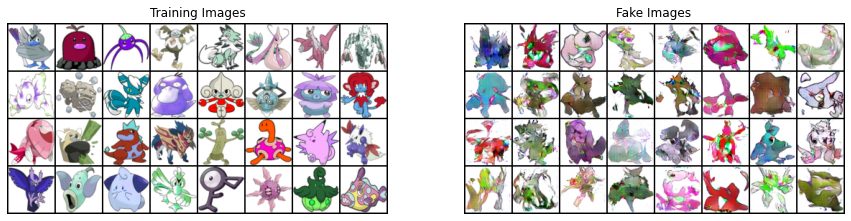

In [ ]:
images_count = 32
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    make_grid(
        next(iter(dataloader))[0][:images_count], padding=2, normalize=True
    ).permute(1, 2, 0)
)

gen_images = model.generate(images_count)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(make_grid(gen_images.cpu(), padding=2, normalize=True).permute(1, 2, 0))
plt.show()

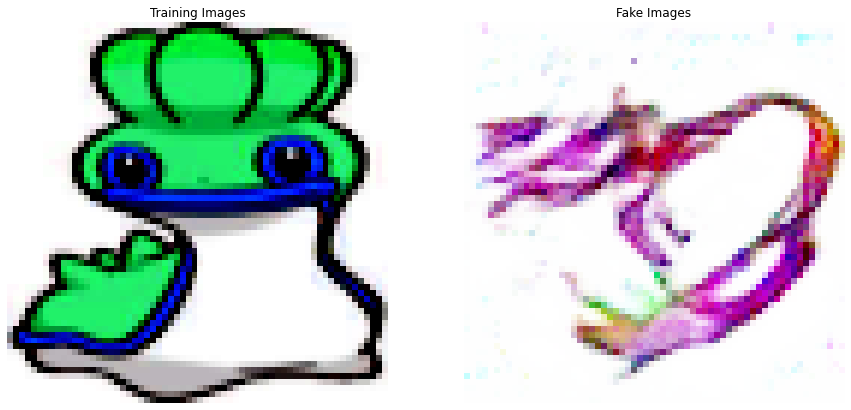

In [ ]:
images_count = 1
image = next(iter(dataloader))[0]
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Training Images")
plt.imshow(image[0].permute(1, 2, 0))

gen_images = model.generate(images_count)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(gen_images[0].cpu().permute(1, 2, 0))
plt.show()